<h1 align="center"> Credit card risk analysis</h1>

<h2 align="center"> Bruno Ortega Goes, M.Sc.</h2>


### Context

Credit score cards are a common risk control method in the financial industry. It uses personal information and data submitted by credit card applicants to predict the probability of future defaults and credit card borrowings. The bank is able to decide whether to issue a credit card to the applicant. Credit scores can objectively quantify the magnitude of risk.
 
Generally speaking, credit score cards are based on historical data. Once encountering large economic fluctuations. Past models may lose their original predictive power. Logistic model is a common method for credit scoring. Because Logistic is suitable for binary classification tasks and can calculate the coefficients of each feature. In order to facilitate understanding and operation, the score card will multiply the logistic regression coefficient by a certain value (such as 100) and round it.
 
At present, with the development of machine learning algorithms. More predictive methods such as Boosting, Random Forest, and Support Vector Machines have been introduced into credit card scoring. However, these methods often do not have good transparency. It may be difficult to provide customers and regulators with a reason for rejection or acceptance.

### Goal

Build a machine learning model to predict if an applicant is 'good' or 'bad' client, different from other tasks, the definition of 'good' or 'bad' is not given. You should use some techique, such as vintage analysis to construct you label. Also, unbalance data problem is a big problem in this task. 

### Content & Explanation

There're two tables could be merged by ID:

application_record.csv 		

* ID: Client number 	
* CODE_GENDER: Gender 	
* FLAG_OWN_CAR: Is there a car 	
* FLAG_OWN_REALTY: Is there a property 	
* CNT_CHILDREN: Number of children 	
* AMT_INCOME_TOTAL: Annual income 	
* NAME_INCOME_TYPE: Income category 	
* NAME_EDUCATION_TYPE: Education level 	
* NAME_FAMILY_STATUS: Marital status 	
* NAME_HOUSING_TYPE: Way of living 	
* DAYS_BIRTH: Birthday. Count backwards from current day (0), -1 means yesterday
* DAYS_EMPLOYED: Start date of employment. Count backwards from current day(0). If positive, it means the person currently unemployed.
* FLAG_MOBIL: Is there a mobile phone.	
* FLAG_WORK_PHONE: Is there a work phone 	
* FLAG_PHONE: Is there a phone 	
* FLAG_EMAIL: Is there an email 	
* OCCUPATION_TYPE: Occupation 	
* CNT_FAM_MEMBERS: Family size 

credit_record.csv 		
* ID: Client number 	
* MONTHS_BALANCE: Record month. The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on
* **STATUS**: Status. 0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month * X: No loan for the month

### References
The dataset used in this project can be found in: https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction (dirty version).

There is also a clean version of this data that can be found in: https://www.kaggle.com/datasets/samuelcortinhas/credit-card-classification-clean-data

Interesting related competition: https://www.kaggle.com/competitions/home-credit-default-risk/data

## Preamble

In [1]:
# Basic working tools
import numpy as np
import pandas as pd

# Plot tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5) # Big fonts

# Save plots at:
import os
nb_directory = os.getcwd() #Set the directory of my notebook
plots_path = nb_directory+'/Plots/' # The plots are saved in a 'Plots' folder in the notebook directory

# Data preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# To make train, test and calibration sets.
from sklearn.model_selection import train_test_split

# Classification models used in this notebook
# Linear model
from sklearn.linear_model import LogisticRegression
# Tree based models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# Distance based model
from sklearn.neighbors import KNeighborsClassifier

# Optimization hyperparameter
from skopt import dummy_minimize

# Classification metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, auc 
from sklearn.metrics import precision_recall_curve, RocCurveDisplay
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn.calibration import calibration_curve # Inspect the calibration
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.metrics import brier_score_loss

# Feature importance
from sklearn.inspection import permutation_importance

# Some styling for my plots
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']}) #Use times fonts
mpl.rcParams['text.usetex'] = True # Beautiful latex fontstyle

import string
alphabet = list(string.ascii_lowercase)
font_size = 22

In [2]:
############################
#
# HOME BUILT FUNCTIONS
#
############################
def save_plot(name_extension):
    '''
    Parameters
    ----------
    name_extension : STRING
        You must provide the name of you plot followed by the type of document in quote marks.
        
        Ex.: 'Fig1.pdf'

    Returns
    -------
    None. Only saves the image.

    '''

    plt.savefig(plots_path+name_extension, bbox_inches = 'tight')
    
    
def metric_printer(y_prediction_proba, y_test, thr = 0.5):
    '''
    Parameters
    ----------
    y_prediction_proba : The result of the predictions using the prediction_proba.
    
    y_test : the y of the test set

    Returns
    -------
    A print of all the metrics I want, similar to clasification report, but here I have control on the threshold.

    '''
    pred = (y_prediction_proba[:,1] > thr).astype(int)
    
    cf = pd.DataFrame(confusion_matrix(y_test,pred))
    
    print('Threshold:', thr)
    print('Precision:', round(precision_score(y_test, pred),2))
    print('Recall:', round(recall_score(y_test, pred),2))
    print('f1 score:', round(f1_score(y_test, pred),2))
    print('ROC-AUC:', round(roc_auc_score(y_test, y_prediction_proba[:,1]),2))
    print('Confunsion matrix:')
    print(cf)
    
    return None

def metric_ploter(y_prediction_proba, y_test, thr_interval = np.arange(0.05, 1., 0.05), save = False, plt_name = 'plotname.pdf'):
    
    # Start the list of the metrics
    lista_precision = []
    lista_recall = []
    lista_f1 =[]

    # Run over the various thresholds to construc the scores
    for thr in thr_interval:
    
        precision_thr = precision_score(y_test, (y_prediction_proba[:,1] > thr).astype(int))
        recall_thr = recall_score(y_test, (y_prediction_proba[:,1] > thr).astype(int))
        f1_thr = f1_score(y_test, (y_prediction_proba[:,1] > thr).astype(int))

        lista_precision.append(precision_thr)
        lista_f1.append(f1_thr)
        lista_recall.append(recall_thr)
    
    # Plot the scores in the same plot
    plt.plot(thr_interval, lista_precision, label='precision')
    plt.plot(thr_interval, lista_recall, label='recall')
    plt.plot(thr_interval, lista_f1, label='f1')
    plt.xlabel('Threshold')
    plt.legend(['precision','recall',r'$f_1$'])
    
    # If I want I can save this plot
    if save == True:
        save_plot('plotname.pdf')
        plt.show()
    else:
        plt.show()
        
    return None

## Part 1: Exploratory analysis

This first part of my workflow I get to understand the dataframes I am working with. 
1. What information do the dataframes contain? 
2. Are there missing features? 
    * If so, how to treat them?
3. Can I come up with new meaningful features?
4. Do I have to take into consideration ethical concerns?
5. What are the caracteristics of my data?

In [3]:
# Loading the datasets
df_application = pd.read_csv('/Users/brunogoes/Dropbox/DataSets/RiskAnalysis/application_record.csv')
df_credit_record = pd.read_csv('/Users/brunogoes/Dropbox/DataSets/RiskAnalysis/credit_record.csv')

* We have 2 data frames that can be joined with the client ID. Let's study each of them separetely.
* In the end I'll create the working dataframe.

### 1. Credit score dataframe

In [4]:
df_credit_record.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


* This dataset contains the information about the client payment history during the different months. The total of data lines is 1 048 575.

In [5]:
df_credit_record.nunique() # Count number of distinct elements in specified axis.

ID                45985
MONTHS_BALANCE       61
STATUS                8
dtype: int64

* This means that we have information about 45985 clients and some clients has up to 60 months of credit history. Let's understand it further:

In [6]:
df_credit_record.head(50)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
5,5001712,-1,C
6,5001712,-2,C
7,5001712,-3,C
8,5001712,-4,C
9,5001712,-5,C


* This is important to understand. The credit credit_record.csv  contains:
		
1. ID: Client number 	
2. MONTHS_BALANCE: Record month. The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on
3. **STATUS**: Status. 0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month * X: No loan for the month.

Let's focus on the client with ID = 5001711

She's been a client for 4 months (counting the current 0 month). In the months -3,-2 and -1 she payed with at least 29 days due the date and in the current month, 0, she hasn't used her credit card X.

Now the client with ID= 5001712

She's been a client for 19 months (19 entries in the record data set), she has always paid with at most 29 days after the due date. And she hasn't used her credit card for several months X.

With this interpretation we can create a rule to consider a good client or a bad one.

There are two ideas used in the community, namely:
* Ever90, which is a conservative strategy. Here, if a client payed in retart sometime during 90 days (3 months) he is considered a bad client;
* Over90, which is a more relaxed strategy. If the client payed past due date at some time but in the end of 90 days he has no debt, everything is fine and he's a good client.
* It's possible to add some complexity considering a 30d+over90 (30 days plus over 90) to tag a good or bad client. Also, it's possible to consider 3 classes in this dataset:
1. Good clients,
2. Bad clients,
3. Julius clients (reference to Everybody hates Chris), i.e., those who have but never uses their credit card (or used at some point and stoped doing so). 

These levels of complexity can be integrated but in a future work. For now for self-pedagogical reasons I'll keep to the **well-done basics**!

The rule to define a good or bad client is not give, it is up to me to create the rule $\cal{M}$ that will classify the clients. This is done below.

* We have 8 status, according to the description of the dataset:
    * 0: 1-29 days past due 
    * 1: 30-59 days past due 
    * 2: 60-89 days overdue 
    * 3: 90-119 days overdue 
    * 4: 120-149 days overdue 
    * 5: Overdue or bad debts, write-offs for more than 150 days 
    * C: paid off that month 
    * X: No loan for the month

* As a first approach I'll consider **bad clients** everyone who takes more that 60 days to pay their debts, i.e., the categories 1-5. These are being classified as 1.
* **Good clients** are categories the ones that paid their debts this month C and category 1. These are being classified as 0.
* X are clients that do not have loans, hence they provide no information and they will be be **dropped** from the working dataset and saved in a second dataset that I'll use to check my predictions. C paid off their debts but we don't know after how long, so they also do not provide useful information. These will receive the class -1.
* Summary:
    * Good: 0
    * Bad : 1
    * Ugly: -1
* The following function classifies the clients:

In [7]:
def client_classifier(id): #ever30d strategy
    
    # Defining the status
    Good = ['C', '0']
    Bad = ['1','2','3','4','5']
    Julius = ['X']
    
    # I take the client status in at most in the actual + 3 last months, if the guy has a bigger credit history he won't be punished
    client_status = df_credit_record[df_credit_record['ID'] == id]['STATUS'].tolist()[:4]
   
    # Bad payer
    if any(status in Bad for status in client_status):
        return 1
    
    # No credit information
    elif all(status in Julius for status in client_status):
        return -1 
    
    # Good payer
    else:
        return 0

* Now I'll create a new datafram that will contain the classification of the clients, according to my rule, and their IDs.

In [8]:
df_client_classification = pd.DataFrame()
df_client_classification

""


In [9]:
# Creating the ID column
df_client_classification['ID'] = df_credit_record['ID'].unique()
df_client_classification

,ID
0,5001711
1,5001712
2,5001713
3,5001714
4,5001715
...,...
45980,5150482
45981,5150483
45982,5150484
45983,5150485


In [10]:
%%time
# Using the function to creating the client classification column:
df_client_classification['CLIENT_CLASSIFICATION'] = df_client_classification['ID'].map(client_classifier)
df_client_classification


CPU times: user 1min 16s, sys: 10.8 s, total: 1min 27s
Wall time: 33 s


,ID,CLIENT_CLASSIFICATION
0,5001711,0
1,5001712,0
2,5001713,-1
3,5001714,-1
4,5001715,-1
...,...,...
45980,5150482,0
45981,5150483,-1
45982,5150484,0
45983,5150485,0


* Now we have a new dataframe with the classification and IDs of each client that has a credit record

In [11]:
df_client_classification.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45985 entries, 0 to 45984
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   ID                     45985 non-null  int64
 1   CLIENT_CLASSIFICATION  45985 non-null  int64
dtypes: int64(2)
memory usage: 718.6 KB


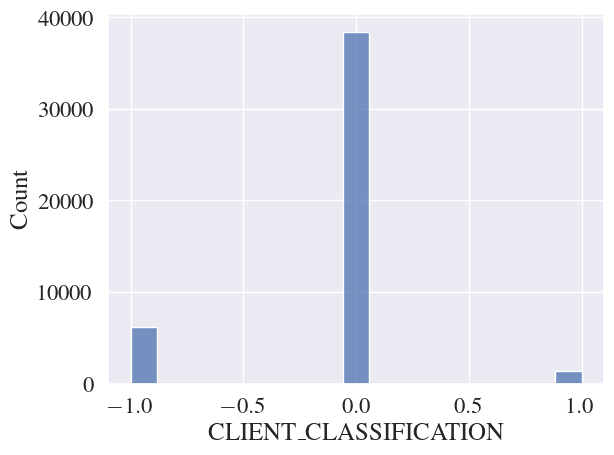

In [12]:
client_classification = df_client_classification['CLIENT_CLASSIFICATION']

# Plot the distribution of the clients
sns.histplot(client_classification)
save_plot('client_classification.pdf')
plt.show()


In [13]:
# Percentages of each client
df_client_classification['CLIENT_CLASSIFICATION'].value_counts(normalize=True)*100



 0    83.596825
-1    13.319561
 1     3.083614
Name: CLIENT_CLASSIFICATION, dtype: float64

* It means that around 83% of my dataset is of good clients, 13% do not use their credit card and only 3% are bad payer. 
* It's not highly unbalanced, but still unbalanced.
* I do not wanna classify the guys who do not use their cards, so in the very end my working dataset will contain only the classes 1 and 0.

### 2.Credit application dataframe 

In [14]:
df_application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

* In this dataframe we have categorical (object) and numerical variables.
* The categorical variables will be encoded and the numerical will be scaled to use the models I intend to use: Logistic regression, Random Forest, XGBoost and KNeighrest neighbors.
* How are these variables?

In [15]:
df_application.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


* There are 3 features that call my attention:
    * Days employed and days birth are counting the days backwards in time. I want them to be in comprehensive numbers, so I'll treat them before training my models.
    * Occupation type has some Nan values, i.e., this information was not provided.
    
* Also, clearly I can create 2 interesting features:
    * Total income divided by the family members, and
    * Total income divided by the number of children
* It might have some impact on how the person use their credit card and how they manage their finances. It is all about salary income that is compromised.

* Are there repeated IDs in the dataset?

In [16]:
sum(df_application['ID'].duplicated())

47

* There are 47 repeated IDs, do they refer to the same person?

In [17]:
df_application[df_application['ID'].isin(df_application['ID'][df_application['ID'].duplicated()])].sort_values('ID')


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
426818,7022197,M,Y,Y,3,135000.0,Working,Secondary / secondary special,Married,House / apartment,-11945,-735,1,0,0,1,Laborers,5.0
425023,7022197,F,N,Y,0,450000.0,Commercial associate,Higher education,Separated,House / apartment,-19813,-1799,1,0,0,1,NaN,1.0
431545,7022327,F,N,Y,0,135000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-14771,-5298,1,0,0,0,High skill tech staff,1.0
431911,7022327,M,Y,Y,0,256500.0,Commercial associate,Higher education,Married,House / apartment,-21503,-1674,1,0,0,1,Core staff,2.0
425486,7023108,M,Y,Y,1,67500.0,Working,Secondary / secondary special,Married,House / apartment,-15156,-1696,1,1,0,0,Core staff,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426563,7836711,F,N,Y,2,292500.0,Working,Higher education,Married,House / apartment,-13747,-4386,1,0,1,0,Accountants,4.0
421464,7836971,M,Y,N,1,157500.0,Working,Secondary / secondary special,Married,House / apartment,-13771,-5520,1,0,0,0,NaN,3.0
428620,7836971,F,N,Y,0,103500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-13383,-2798,1,0,1,0,Sales staff,2.0
422068,7838075,M,N,Y,0,337500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-18198,-1275,1,0,0,1,Drivers,2.0


* The repeated IDs refer to different profiles of clients, they have different genders most of the time. I imagine they are couples. 
* For the moment, since it is just 47 repeated entries, I choose to get rid of the repeated IDs before joining the datasets.
    * Other strategy could be leave the older client.

In [18]:
df_application = df_application.drop_duplicates(subset = 'ID', keep = False, inplace = False)

In [19]:
sum(df_application['ID'].duplicated())

0

### Merging the datasets

In [20]:
df_merged = pd.merge(df_application, df_client_classification, on='ID')

In [21]:
df_merged.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CLIENT_CLASSIFICATION
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-1


* Checking their shapes

In [22]:
df_application.shape, df_client_classification.shape, df_merged.shape  # Os cabras que nao consiguiram o cartao sao os rejeitados


((438463, 18), (45985, 2), (36457, 19))

In [23]:
len(set(df_application.ID).intersection(set(df_client_classification.ID)))

36457

* It can be interpreted aa some of the clients that applied didn't have the credit line, some that already have for a long time are not in the application data set anymore.
* Are there missing values?

In [24]:
np.sum(df_merged.isnull()).T

ID                           0
CODE_GENDER                  0
FLAG_OWN_CAR                 0
FLAG_OWN_REALTY              0
CNT_CHILDREN                 0
AMT_INCOME_TOTAL             0
NAME_INCOME_TYPE             0
NAME_EDUCATION_TYPE          0
NAME_FAMILY_STATUS           0
NAME_HOUSING_TYPE            0
DAYS_BIRTH                   0
DAYS_EMPLOYED                0
FLAG_MOBIL                   0
FLAG_WORK_PHONE              0
FLAG_PHONE                   0
FLAG_EMAIL                   0
OCCUPATION_TYPE          11323
CNT_FAM_MEMBERS              0
CLIENT_CLASSIFICATION        0
dtype: int64

* As we have seen before only the occupation type has missing values.

In [25]:
df_merged['OCCUPATION_TYPE'].count()/df_merged['ID'].count()

0.6894149271744795

In [26]:
df_merged.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,CLIENT_CLASSIFICATION
count,3.645700e+04,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.0,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000
mean,5.078227e+06,0.430315,1.866857e+05,-15975.173382,59262.935568,1.0,0.225526,0.294813,0.089722,2.198453,-0.090051
std,4.187524e+04,0.742367,1.017892e+05,4200.549944,137651.334859,0.0,0.417934,0.455965,0.285787,0.911686,0.381553
min,5.008804e+06,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-1.000000
25%,5.042028e+06,0.000000,1.215000e+05,-19438.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,0.000000
50%,5.074614e+06,0.000000,1.575000e+05,-15563.000000,-1552.000000,1.0,0.000000,0.000000,0.000000,2.000000,0.000000
75%,5.115396e+06,1.000000,2.250000e+05,-12462.000000,-408.000000,1.0,0.000000,1.000000,0.000000,3.000000,0.000000
max,5.150487e+06,19.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,1.000000


### 3.Data treatment 
In this section I address the following:

1) I pre-process the needed features: DAYS_BIRTH, DAYS_EMPLOYED
2) I create the features: 
    * AMT_INCOME_PER_PERSON that is the ratio between the total income, AMT_INCOME_TOTAL, and the total family members, CNT_FAM_MEMBERS, of each client, and
    * AMT_INCOME_PER_CHILD that is the ratio between the total income, AMT_INCOME_TOTAL, and the total of children, CNT_CHILDREN. This is set to 0 if the client has no children.
3) Distributions of the features?
    * Are there more man or women asking for credit?
    * More maried or single?
    * Family members?
    * Housing type?

#### 1) Dealing with missing values in occupation type

* The OCCUPATION column that has 70% of missing values will have 'Not provided' as Nan.

In [27]:
# Where there is Nan, substitute with Not provided
df_merged['OCCUPATION_TYPE'].fillna('Not provided', inplace = True)

In [28]:
df_merged.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CLIENT_CLASSIFICATION
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,Not provided,2.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,Not provided,2.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-1


In [29]:
np.sum(df_merged.isnull()).T

ID                       0
CODE_GENDER              0
FLAG_OWN_CAR             0
FLAG_OWN_REALTY          0
CNT_CHILDREN             0
AMT_INCOME_TOTAL         0
NAME_INCOME_TYPE         0
NAME_EDUCATION_TYPE      0
NAME_FAMILY_STATUS       0
NAME_HOUSING_TYPE        0
DAYS_BIRTH               0
DAYS_EMPLOYED            0
FLAG_MOBIL               0
FLAG_WORK_PHONE          0
FLAG_PHONE               0
FLAG_EMAIL               0
OCCUPATION_TYPE          0
CNT_FAM_MEMBERS          0
CLIENT_CLASSIFICATION    0
dtype: int64

#### 2) Adjusting age and days employed
* I transform the 'DAYS_BIRTH' into 'AGE' by diving this values by 365.25 (.25 accounts for the leap years)

In [30]:
#the - sign is to take into account the backwards count
df_merged['AGE'] = -round(df_merged['DAYS_BIRTH']/365.25,0) # Create the AGE
df_merged = df_merged.drop('DAYS_BIRTH', axis = 1) #Exclued the days birth

df_merged['YEARS_EMPLOYED'] = -round(df_merged['DAYS_EMPLOYED']/365.25,0)
df_merged = df_merged.drop('DAYS_EMPLOYED', axis = 1)



In [31]:
df_merged

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CLIENT_CLASSIFICATION,AGE,YEARS_EMPLOYED
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Not provided,2.0,0,33.0,12.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Not provided,2.0,0,33.0,12.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2.0,0,59.0,3.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,52.0,8.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,-1,52.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Managers,2.0,1,47.0,7.0
36453,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,1,0,1,1,Medicine staff,2.0,0,34.0,4.0
36454,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,1,0,1,1,Medicine staff,2.0,0,34.0,4.0
36455,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Sales staff,2.0,1,49.0,2.0


In [32]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     36457 non-null  int64  
 1   CODE_GENDER            36457 non-null  object 
 2   FLAG_OWN_CAR           36457 non-null  object 
 3   FLAG_OWN_REALTY        36457 non-null  object 
 4   CNT_CHILDREN           36457 non-null  int64  
 5   AMT_INCOME_TOTAL       36457 non-null  float64
 6   NAME_INCOME_TYPE       36457 non-null  object 
 7   NAME_EDUCATION_TYPE    36457 non-null  object 
 8   NAME_FAMILY_STATUS     36457 non-null  object 
 9   NAME_HOUSING_TYPE      36457 non-null  object 
 10  FLAG_MOBIL             36457 non-null  int64  
 11  FLAG_WORK_PHONE        36457 non-null  int64  
 12  FLAG_PHONE             36457 non-null  int64  
 13  FLAG_EMAIL             36457 non-null  int64  
 14  OCCUPATION_TYPE        36457 non-null  object 
 15  CN

In [33]:
df_merged.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,CLIENT_CLASSIFICATION,AGE,YEARS_EMPLOYED
count,3.645700e+04,36457.000000,3.645700e+04,36457.0,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000
mean,5.078227e+06,0.430315,1.866857e+05,1.0,0.225526,0.294813,0.089722,2.198453,-0.090051,43.746057,-162.243657
std,4.187524e+04,0.742367,1.017892e+05,0.0,0.417934,0.455965,0.285787,0.911686,0.381553,11.513873,376.881770
min,5.008804e+06,0.000000,2.700000e+04,1.0,0.000000,0.000000,0.000000,1.000000,-1.000000,21.000000,-1000.000000
25%,5.042028e+06,0.000000,1.215000e+05,1.0,0.000000,0.000000,0.000000,2.000000,0.000000,34.000000,1.000000
50%,5.074614e+06,0.000000,1.575000e+05,1.0,0.000000,0.000000,0.000000,2.000000,0.000000,43.000000,4.000000
75%,5.115396e+06,1.000000,2.250000e+05,1.0,0.000000,1.000000,0.000000,3.000000,0.000000,53.000000,9.000000
max,5.150487e+06,19.000000,1.575000e+06,1.0,1.000000,1.000000,1.000000,20.000000,1.000000,69.000000,43.000000


* This -1000 in the years employed is clearly bizarre! 
* I'll interpret these negative values as an indicator of unemployed credit card holders.

In [34]:
df_merged.loc[df_merged['YEARS_EMPLOYED'] < 0, 'YEARS_EMPLOYED'] = 0

In [35]:
df_merged.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CLIENT_CLASSIFICATION,AGE,YEARS_EMPLOYED
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Not provided,2.0,0,33.0,12.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Not provided,2.0,0,33.0,12.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2.0,0,59.0,3.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,52.0,8.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,-1,52.0,8.0


In [36]:
#years_employed_for_histogram = df_merged[df_merged['YEARS_EMPLOYED']]

# Plot the distribution of the clients
#sns.histplot(years_employed_for_histogram)
#save_plot('client_classification.pdf')
#plt.show()

In [37]:
df_merged.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,CLIENT_CLASSIFICATION,AGE,YEARS_EMPLOYED
count,3.645700e+04,36457.000000,3.645700e+04,36457.0,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000
mean,5.078227e+06,0.430315,1.866857e+05,1.0,0.225526,0.294813,0.089722,2.198453,-0.090051,43.746057,6.036783
std,4.187524e+04,0.742367,1.017892e+05,0.0,0.417934,0.455965,0.285787,0.911686,0.381553,11.513873,6.488058
min,5.008804e+06,0.000000,2.700000e+04,1.0,0.000000,0.000000,0.000000,1.000000,-1.000000,21.000000,0.000000
25%,5.042028e+06,0.000000,1.215000e+05,1.0,0.000000,0.000000,0.000000,2.000000,0.000000,34.000000,1.000000
50%,5.074614e+06,0.000000,1.575000e+05,1.0,0.000000,0.000000,0.000000,2.000000,0.000000,43.000000,4.000000
75%,5.115396e+06,1.000000,2.250000e+05,1.0,0.000000,1.000000,0.000000,3.000000,0.000000,53.000000,9.000000
max,5.150487e+06,19.000000,1.575000e+06,1.0,1.000000,1.000000,1.000000,20.000000,1.000000,69.000000,43.000000


In [38]:
negative_values_years_employed = df_merged[df_merged['YEARS_EMPLOYED'] < 0]

bad_clients_number = df_merged[df_merged['CLIENT_CLASSIFICATION']==1]
good_clients_number = df_merged[df_merged['CLIENT_CLASSIFICATION']==0]

#negative_values_years_employed = df_merged[df_merged['YEARS_EMPLOYED'] < 0]

In [39]:
negative_values_years_employed.count()

ID                       0
CODE_GENDER              0
FLAG_OWN_CAR             0
FLAG_OWN_REALTY          0
CNT_CHILDREN             0
AMT_INCOME_TOTAL         0
NAME_INCOME_TYPE         0
NAME_EDUCATION_TYPE      0
NAME_FAMILY_STATUS       0
NAME_HOUSING_TYPE        0
FLAG_MOBIL               0
FLAG_WORK_PHONE          0
FLAG_PHONE               0
FLAG_EMAIL               0
OCCUPATION_TYPE          0
CNT_FAM_MEMBERS          0
CLIENT_CLASSIFICATION    0
AGE                      0
YEARS_EMPLOYED           0
dtype: int64

In [40]:
good_clients_number.count()

ID                       30854
CODE_GENDER              30854
FLAG_OWN_CAR             30854
FLAG_OWN_REALTY          30854
CNT_CHILDREN             30854
AMT_INCOME_TOTAL         30854
NAME_INCOME_TYPE         30854
NAME_EDUCATION_TYPE      30854
NAME_FAMILY_STATUS       30854
NAME_HOUSING_TYPE        30854
FLAG_MOBIL               30854
FLAG_WORK_PHONE          30854
FLAG_PHONE               30854
FLAG_EMAIL               30854
OCCUPATION_TYPE          30854
CNT_FAM_MEMBERS          30854
CLIENT_CLASSIFICATION    30854
AGE                      30854
YEARS_EMPLOYED           30854
dtype: int64

#### 3) Feature engineering

In [41]:
# total income / person
df_merged['AMT_INCOME_PER_PERSON'] = df_merged['AMT_INCOME_TOTAL']/df_merged['CNT_FAM_MEMBERS']



In [42]:
def amt_per_child(dataframe):
    if dataframe['CNT_CHILDREN'] == 0:
        return -1 # this is a value that can't exist
    else:
        return dataframe['AMT_INCOME_TOTAL']/dataframe['CNT_CHILDREN']

In [43]:
df_merged['AMT_INCOME_PER_CHILD'] = df_merged.apply(amt_per_child, axis = 1)



In [44]:
np.sum(df_merged.isnull()).T

ID                       0
CODE_GENDER              0
FLAG_OWN_CAR             0
FLAG_OWN_REALTY          0
CNT_CHILDREN             0
AMT_INCOME_TOTAL         0
NAME_INCOME_TYPE         0
NAME_EDUCATION_TYPE      0
NAME_FAMILY_STATUS       0
NAME_HOUSING_TYPE        0
FLAG_MOBIL               0
FLAG_WORK_PHONE          0
FLAG_PHONE               0
FLAG_EMAIL               0
OCCUPATION_TYPE          0
CNT_FAM_MEMBERS          0
CLIENT_CLASSIFICATION    0
AGE                      0
YEARS_EMPLOYED           0
AMT_INCOME_PER_PERSON    0
AMT_INCOME_PER_CHILD     0
dtype: int64

#### 4) Creating the working dataset and the one with the "Julius" clients

In [45]:
df_work = df_merged[df_merged['CLIENT_CLASSIFICATION'] != -1]
df_juli = df_merged[df_merged['CLIENT_CLASSIFICATION'] == -1]

### 4. Some histograms

## Part 2: Modeling and training

This is the core of this project. The steps are as indicated:
It is important to take into account that this dataset is highly unbalanced. I will not use any resempling technique. Undersampling makes us loose information, oversample can lead to high bias and SMOTE does not work well.  
1. I'll use the following models to this problem:
    * Logistic regression
    * Random Forest
    * XGBoost
    * KNeighbors
* I do not want to train **sexist models**, i.e., a model that takes into account the gender of the client when classifiyng him/her as a good or bad payer.
  
* In a first moment I'll just run the models with the default parameters and check what is the ROC-AUC and $f_1$ scores. Then, for each model I will perform a **hyperparameter optimization** for the best models
* I'll use 10-fold cross validation
    * I'll use the ROC-AUC as the main classification metric, I'll also check which is the best threshold to set to obtain a good tradeoff between precision and recall.
2. Feature importance for each model.

4. Models performance evaluation (using test dataset)
    * Predictions in the test dataset
    * The veredict **confusion matrices**
    * Classification report for the chosen model
    
5. Summary and discussion
    * Chosen model and figures of merit
    
A cool answer I found looking for some interpretation on ROC and $f_1$ scores: 
   * high AUC ROC vs low f1 or other "point" metric, means that your classifier currently does a bad job, however you can find the threshold for which its score is actually pretty decent
   * low AUC ROC and low f1 or other "point" metric, means that your classifier currently does a bad job, and even fitting a threshold will not change it
   * high AUC ROC and high f1 or other "point" metric, means that your classifier currently does a decent job, and for many other values of threshold it would do the same
   * low AUC ROC vs high f1 or other "point" metric, means that your classifier currently does a decent job, however for many other values of threshold - it is pretty bad

    
#### References
1. Treating unbalanced datasets (in portuguese): https://medium.com/datalab-log/voc%C3%AA-deve-calibrar-seu-modelo-desbalanceado-ou-n%C3%A3o-3f111160653a
2. XGBoost tutorial: https://www.datacamp.com/tutorial/xgboost-in-python
3. SVM tutorial: https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python
4. KNeighbors tutorial: https://www.datacamp.com/tutorial/k-nearest-neighbor-classification-scikit-learn
5. LighGBM documentation: https://lightgbm.readthedocs.io/en/stable/
6. StackExchange discussion: https://stackoverflow.com/questions/34698161/how-to-interpret-almost-perfect-accuracy-and-auc-roc-but-zero-f1-score-precisio
7. Pipeline construction: https://towardsdatascience.com/building-a-machine-learning-pipeline-3bba20c2352b
8. Feature importance - Permutation importance vs. Random Forest Feature Importance: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

#### 1) Training, calibration and test sets

In [46]:
# The target is
y = df_work.CLIENT_CLASSIFICATION

# I take off the ID and GENDER and the target
X = df_work.drop(['ID', 'CODE_GENDER', 'CLIENT_CLASSIFICATION'], axis =1)

# The columns that has numerical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns

# The categorical features
categorical_features = X.select_dtypes(include=['object']).columns

# These columns need encoding
print(categorical_features)
print(numerical_features)

Index(['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE'],
      dtype='object')
Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'FLAG_MOBIL', 'FLAG_WORK_PHONE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'AGE', 'YEARS_EMPLOYED',
       'AMT_INCOME_PER_PERSON', 'AMT_INCOME_PER_CHILD'],
      dtype='object')


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42,stratify=y)


X_train, X_calib, y_train, y_calib = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)



In [48]:
X_test.shape

(6403, 18)

In [49]:
X_train.shape

(23049, 18)

In [50]:
X_calib.shape

(2562, 18)

#### General preprocessing steps

In [51]:
# To scale numerical features
scaler = RobustScaler()

# To encode categorical features
encoder = ce.TargetEncoder(cols = categorical_features)

# Making a preprocessor with the scaler and encoder
preprocessor = ColumnTransformer(
      transformers=[('numerical_features', scaler, numerical_features),
                    ('categorical_features', encoder, categorical_features)])

* I'll mostly be using tree based models, so the scaler is somehow indifferent, but for the Logistic regression and KNearest Neighbors model the scaling of the numerical features is important. 
* For **consistency** of the comparison I apply the same pre-processing for all models, i.e., the numerical and categorical features are always scaled and encoded in the same manner.

#### 0.Simple model 
* Here I want to have a baseline. If I consider a very simple function, is it already enough to classify the users?

In [52]:
def simple_model(df, a = 1, w = 1/(200*10**3), e = 2):
    age = df.AGE
    salary = df.AMT_INCOME_TOTAL
    employment_time = df.YEARS_EMPLOYED
    
    return - a*age #+ w*salary + e*employment_time

In [53]:
simple_model(X_test)

22635   -64.0
24569   -40.0
14271   -55.0
4884    -36.0
12647   -56.0
         ... 
22496   -59.0
32292   -50.0
20743   -57.0
2761    -42.0
2839    -57.0
Name: AGE, Length: 6403, dtype: float64

In [54]:
roc_auc_score(y_test, simple_model(X_test))

0.5566742941120592

#### 1. Training default models and checking the ROC-AUC provided


In [55]:
def train_default_model(model, X_train = X_train, y_train = y_train, X_test = X_test):
    mdl = make_pipeline(preprocessor, model)
    mdl.fit(X_train, y_train)

    pred = mdl.predict_proba(X_test)[:,1]
    
    rocauc = roc_auc_score(y_test, pred)
    
    return rocauc

In [56]:
train_default_model(LogisticRegression())

0.5445779480216139

In [57]:
train_default_model(RandomForestClassifier())

0.7066803709229489

In [58]:
train_default_model(XGBClassifier())

0.6434553445202533

In [59]:
train_default_model(KNeighborsClassifier())

0.6276175688286143

#### Functions to do hyperparameter optimization

In [60]:
def train_LR(params, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    C = params[0]
    solver = params[1]
    max_iter = params[2]
    tol = params[3]
    class_weigth = params[4]
    
    model = LogisticRegression(C=C, solver=solver, max_iter=max_iter,tol=tol, class_weight=class_weigth)
    
    mdl = make_pipeline(preprocessor, model)
    
    mdl.fit(X_train, y_train)
    
    pred = mdl.predict_proba(X_test)[:,1]
    
    return -roc_auc_score(y_test, pred)

parameter_space_LR = [
    (0.001, 10.0),  # C (Regularization Strength)
    ('liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'),  # solver
    (100, 10000),   # max_iter (Max Iterations)
    (1e-4, 1e-2),    # tol (Tolerance)
    (None, 'balanced') # Class_weigth
]

In [61]:
%%time
optimization_result_LR = dummy_minimize(train_LR, parameter_space_LR, random_state=42,verbose=1,n_calls = 100)


Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.3475
Function value obtained: -0.5547
Current minimum: -0.5547
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.4228
Function value obtained: -0.5559
Current minimum: -0.5559
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.4543
Function value obtained: -0.5585
Current minimum: -0.5585
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.2581
Function value obtained: -0.5419
Current minimum: -0.5585
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.3256
Function value obtained: -0.5580
Current minimum: -0.5585
Iteration No: 6 started. 

Iteration No: 43 ended. Evaluation done at random point.
Time taken: 0.2634
Function value obtained: -0.5526
Current minimum: -0.5588
Iteration No: 44 started. Evaluating function at random point.
Iteration No: 44 ended. Evaluation done at random point.
Time taken: 0.3089
Function value obtained: -0.5582
Current minimum: -0.5588
Iteration No: 45 started. Evaluating function at random point.
Iteration No: 45 ended. Evaluation done at random point.
Time taken: 0.3327
Function value obtained: -0.5576
Current minimum: -0.5588
Iteration No: 46 started. Evaluating function at random point.
Iteration No: 46 ended. Evaluation done at random point.
Time taken: 0.4254
Function value obtained: -0.5586
Current minimum: -0.5588
Iteration No: 47 started. Evaluating function at random point.
Iteration No: 47 ended. Evaluation done at random point.
Time taken: 0.3206
Function value obtained: -0.5579
Current minimum: -0.5588
Iteration No: 48 started. Evaluating function at random point.
Iteration No: 4

Iteration No: 85 ended. Evaluation done at random point.
Time taken: 0.4607
Function value obtained: -0.5585
Current minimum: -0.5589
Iteration No: 86 started. Evaluating function at random point.
Iteration No: 86 ended. Evaluation done at random point.
Time taken: 0.6972
Function value obtained: -0.5463
Current minimum: -0.5589
Iteration No: 87 started. Evaluating function at random point.
Iteration No: 87 ended. Evaluation done at random point.
Time taken: 0.2834
Function value obtained: -0.5586
Current minimum: -0.5589
Iteration No: 88 started. Evaluating function at random point.
Iteration No: 88 ended. Evaluation done at random point.
Time taken: 0.9470
Function value obtained: -0.5429
Current minimum: -0.5589
Iteration No: 89 started. Evaluating function at random point.
Iteration No: 89 ended. Evaluation done at random point.
Time taken: 0.3918
Function value obtained: -0.5590
Current minimum: -0.5590
Iteration No: 90 started. Evaluating function at random point.
Iteration No: 9

In [62]:
optimization_result_LR.fun

-0.5589513519856504

In [63]:
best_parameters_LR = optimization_result_LR.x
best_parameters_LR

[4.9447086267211136, 'liblinear', 4829, 0.004471151963596434, 'balanced']

In [64]:
def train_RF(params, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    n_estimators = params[0]
    criterion = params[1]
    max_depth = params[2]
    min_samples_split = params[3]
    min_samples_leaf = params[4]
    class_weight = params[5]
    
    model = RandomForestClassifier(n_estimators= n_estimators, criterion = criterion, max_depth=max_depth, min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf, class_weight=class_weight, n_jobs = -1, random_state=42)
    
    mdl = make_pipeline(preprocessor, model)
    
    mdl.fit(X_train, y_train)
    
    pred = mdl.predict_proba(X_test)[:,1]
    
    return -roc_auc_score(y_test, pred)

parameter_space_RF = [(100,500),          #n_estimators
                     ('gini','entropy'),  #criterion
                     (10,30),             #max_depth
                     (2,20),              #min_samples_split
                     (5,20),              #min_samples_leaf
                     (None, "balanced", "balanced_subsample")]  #Class_weigth




In [65]:
%%time
optimization_result_RF = dummy_minimize(train_RF, parameter_space_RF, random_state=42,verbose=1,n_calls = 100)



Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.5851
Function value obtained: -0.6367
Current minimum: -0.6367
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.6091
Function value obtained: -0.6450
Current minimum: -0.6450
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.0490
Function value obtained: -0.6591
Current minimum: -0.6591
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.4360
Function value obtained: -0.6397
Current minimum: -0.6591
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.0614
Function value obtained: -0.6428
Current minimum: -0.6591
Iteration No: 6 started. 

Iteration No: 43 ended. Evaluation done at random point.
Time taken: 0.8376
Function value obtained: -0.6415
Current minimum: -0.6642
Iteration No: 44 started. Evaluating function at random point.
Iteration No: 44 ended. Evaluation done at random point.
Time taken: 0.8230
Function value obtained: -0.6197
Current minimum: -0.6642
Iteration No: 45 started. Evaluating function at random point.
Iteration No: 45 ended. Evaluation done at random point.
Time taken: 1.8938
Function value obtained: -0.6484
Current minimum: -0.6642
Iteration No: 46 started. Evaluating function at random point.
Iteration No: 46 ended. Evaluation done at random point.
Time taken: 2.3217
Function value obtained: -0.6491
Current minimum: -0.6642
Iteration No: 47 started. Evaluating function at random point.
Iteration No: 47 ended. Evaluation done at random point.
Time taken: 0.8675
Function value obtained: -0.6546
Current minimum: -0.6642
Iteration No: 48 started. Evaluating function at random point.
Iteration No: 4

Iteration No: 85 ended. Evaluation done at random point.
Time taken: 1.9028
Function value obtained: -0.6330
Current minimum: -0.6642
Iteration No: 86 started. Evaluating function at random point.
Iteration No: 86 ended. Evaluation done at random point.
Time taken: 1.6157
Function value obtained: -0.6475
Current minimum: -0.6642
Iteration No: 87 started. Evaluating function at random point.
Iteration No: 87 ended. Evaluation done at random point.
Time taken: 2.7488
Function value obtained: -0.6476
Current minimum: -0.6642
Iteration No: 88 started. Evaluating function at random point.
Iteration No: 88 ended. Evaluation done at random point.
Time taken: 0.6679
Function value obtained: -0.6478
Current minimum: -0.6642
Iteration No: 89 started. Evaluating function at random point.
Iteration No: 89 ended. Evaluation done at random point.
Time taken: 1.0528
Function value obtained: -0.6200
Current minimum: -0.6642
Iteration No: 90 started. Evaluating function at random point.
Iteration No: 9

In [66]:
optimization_result_RF.fun

-0.6641758726859225

In [67]:
best_parameters_RF = optimization_result_RF.x
best_parameters_RF

[297, 'entropy', 18, 6, 5, None]

In [68]:
def train_XGBoost(params, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    n_estimators = params[0]
    max_depth = params[1]
    max_leaves = params[2]
    
    model = XGBClassifier(n_estimators = n_estimators, max_depth = max_depth, max_leaves = max_leaves , n_jobs = -1)
    
    mdl = make_pipeline(preprocessor, model)
    
    mdl.fit(X_train, y_train)
    
    pred = mdl.predict_proba(X_test)[:,1]
    
    return -roc_auc_score(y_test, pred)

parameter_space_XGB = [(100,500), #n_estimators
                     (10,30),     #max_depth
                     (2,20)]      #max_leaves

In [69]:
%%time
optimizaion_result_XGB = dummy_minimize(train_XGBoost, parameter_space_XGB, random_state=42,verbose=1,n_calls = 100)



Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 10.3484
Function value obtained: -0.6620
Current minimum: -0.6620
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 4.4412
Function value obtained: -0.6537
Current minimum: -0.6620
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 5.7613
Function value obtained: -0.6615
Current minimum: -0.6620
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 4.8949
Function value obtained: -0.6540
Current minimum: -0.6620
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 5.9500
Function value obtained: -0.6583
Current minimum: -0.6620
Iteration No: 6 started.

Iteration No: 43 ended. Evaluation done at random point.
Time taken: 6.2227
Function value obtained: -0.6581
Current minimum: -0.6667
Iteration No: 44 started. Evaluating function at random point.
Iteration No: 44 ended. Evaluation done at random point.
Time taken: 2.3763
Function value obtained: -0.6483
Current minimum: -0.6667
Iteration No: 45 started. Evaluating function at random point.
Iteration No: 45 ended. Evaluation done at random point.
Time taken: 8.5365
Function value obtained: -0.6656
Current minimum: -0.6667
Iteration No: 46 started. Evaluating function at random point.
Iteration No: 46 ended. Evaluation done at random point.
Time taken: 5.6533
Function value obtained: -0.6516
Current minimum: -0.6667
Iteration No: 47 started. Evaluating function at random point.
Iteration No: 47 ended. Evaluation done at random point.
Time taken: 6.4933
Function value obtained: -0.6567
Current minimum: -0.6667
Iteration No: 48 started. Evaluating function at random point.
Iteration No: 4

Iteration No: 85 ended. Evaluation done at random point.
Time taken: 4.5626
Function value obtained: -0.6519
Current minimum: -0.6670
Iteration No: 86 started. Evaluating function at random point.
Iteration No: 86 ended. Evaluation done at random point.
Time taken: 5.7015
Function value obtained: -0.6607
Current minimum: -0.6670
Iteration No: 87 started. Evaluating function at random point.
Iteration No: 87 ended. Evaluation done at random point.
Time taken: 2.9569
Function value obtained: -0.6548
Current minimum: -0.6670
Iteration No: 88 started. Evaluating function at random point.
Iteration No: 88 ended. Evaluation done at random point.
Time taken: 11.5110
Function value obtained: -0.6598
Current minimum: -0.6670
Iteration No: 89 started. Evaluating function at random point.
Iteration No: 89 ended. Evaluation done at random point.
Time taken: 3.6438
Function value obtained: -0.6567
Current minimum: -0.6670
Iteration No: 90 started. Evaluating function at random point.
Iteration No: 

In [70]:
optimizaion_result_XGB.fun

-0.6669502511748501

In [71]:
best_parameters_XGB = optimizaion_result_XGB.x
best_parameters_XGB

[383, 21, 13]

In [72]:
def train_KNeighbors(params, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    par0 = params[0]
    par1 = params[1]
    par2 = params[2]
    par3 = params[3]
    
    
    model = KNeighborsClassifier(n_neighbors=par0, weights=par1, leaf_size=par2, p=par3)
    
    mdl = make_pipeline(preprocessor, model)

    mdl.fit(X_train, y_train)

    pred = mdl.predict_proba(X_test)[:,1]

    return -roc_auc_score(y_test, pred)

parameter_space_K = [(1,40), # number of neighbors
                      ('uniform', 'distance'), #weights
                      (1,50), # leaf size
                      [1,2]] #p Manhatan or euclidian distance

In [73]:
%%time
optimization_result_KNeighbors = dummy_minimize(train_KNeighbors, parameter_space_K, random_state=42, verbose=1, n_calls = 100)



Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.7873
Function value obtained: -0.5859
Current minimum: -0.5859
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.6630
Function value obtained: -0.5963
Current minimum: -0.5963
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.3359
Function value obtained: -0.6106
Current minimum: -0.6106
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.3650
Function value obtained: -0.6501
Current minimum: -0.6501
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.6428
Function value obtained: -0.5910
Current minimum: -0.6501
Iteration No: 6 started. 

Iteration No: 43 ended. Evaluation done at random point.
Time taken: 0.6403
Function value obtained: -0.6189
Current minimum: -0.6693
Iteration No: 44 started. Evaluating function at random point.
Iteration No: 44 ended. Evaluation done at random point.
Time taken: 0.6484
Function value obtained: -0.6227
Current minimum: -0.6693
Iteration No: 45 started. Evaluating function at random point.
Iteration No: 45 ended. Evaluation done at random point.
Time taken: 0.3567
Function value obtained: -0.6501
Current minimum: -0.6693
Iteration No: 46 started. Evaluating function at random point.
Iteration No: 46 ended. Evaluation done at random point.
Time taken: 0.3786
Function value obtained: -0.6501
Current minimum: -0.6693
Iteration No: 47 started. Evaluating function at random point.
Iteration No: 47 ended. Evaluation done at random point.
Time taken: 0.6535
Function value obtained: -0.6192
Current minimum: -0.6693
Iteration No: 48 started. Evaluating function at random point.
Iteration No: 4

Iteration No: 85 ended. Evaluation done at random point.
Time taken: 0.3464
Function value obtained: -0.5819
Current minimum: -0.6696
Iteration No: 86 started. Evaluating function at random point.
Iteration No: 86 ended. Evaluation done at random point.
Time taken: 0.3511
Function value obtained: -0.6191
Current minimum: -0.6696
Iteration No: 87 started. Evaluating function at random point.
Iteration No: 87 ended. Evaluation done at random point.
Time taken: 0.4007
Function value obtained: -0.6533
Current minimum: -0.6696
Iteration No: 88 started. Evaluating function at random point.
Iteration No: 88 ended. Evaluation done at random point.
Time taken: 0.3760
Function value obtained: -0.5729
Current minimum: -0.6696
Iteration No: 89 started. Evaluating function at random point.
Iteration No: 89 ended. Evaluation done at random point.
Time taken: 0.3544
Function value obtained: -0.5713
Current minimum: -0.6696
Iteration No: 90 started. Evaluating function at random point.
Iteration No: 9

In [74]:
optimization_result_KNeighbors.fun

-0.6695887745237735

In [75]:
best_parameters_KNeighbors = optimization_result_KNeighbors.x
best_parameters_KNeighbors

[35, 'distance', 16, 1]

In [76]:
# Collecting the best parameters
#best_parameters_LR = [6.100356581168429, 'saga', 8326, 0.009102271980579944, None]
#best_parameters_RF = [297, 'entropy', 18, 6, 5, None]
#best_parameters_XGB = [266, 27, 5]
#best_parameters_KNeighbors = [35, 'distance', 16, 1]

* Now we have the parameters that provide the highest ROC-AUC for each model. These are going to be the values from now on.
* Next steps are to check the cross validation and the $f_1$, precision and recal scores for each model, with the appropriate threshold.
* Also, I'll check the permutation importance. And for the random forest I can see the Random forest importance.
* These steps will conclude the analysis of the models.

In [77]:
# Writing the pipelines for each model

# The models with the optimized hyperparameters are:
LR_with_optimized_parameters = LogisticRegression(C=best_parameters_LR[0], solver=best_parameters_LR[1], max_iter=best_parameters_LR[2],tol=best_parameters_LR[3], class_weight=best_parameters_LR[4])
RF_with_optimized_parameters = RandomForestClassifier(n_estimators= best_parameters_RF[0], criterion = best_parameters_RF[1], max_depth=best_parameters_RF[2], min_samples_split=best_parameters_RF[3],min_samples_leaf=best_parameters_RF[4], class_weight=best_parameters_RF[5], n_jobs = -1, random_state=42)
XGB_with_optimized_parameters = XGBClassifier(n_estimators = best_parameters_XGB[0], max_depth = best_parameters_XGB[1], max_leaves = best_parameters_XGB[2], n_jobs = -1)
KN_with_optimized_parameters = KNeighborsClassifier(n_neighbors=best_parameters_KNeighbors[0], weights=best_parameters_KNeighbors[1], leaf_size=best_parameters_KNeighbors[2], p=best_parameters_KNeighbors[3])

# The optimal pipelines for each models are:
pipeline_LR_optimal = make_pipeline(preprocessor, LR_with_optimized_parameters)
pipeline_RF_optimal = make_pipeline(preprocessor, RF_with_optimized_parameters)
pipeline_XGB_optimal= make_pipeline(preprocessor, XGB_with_optimized_parameters)
pipeline_KN_optimal = make_pipeline(preprocessor, KN_with_optimized_parameters) 

* How are the 10-fold cross-validated scores for each model?

#### ROC-AUC 10-fold cross-validation for each model

In [78]:
%%time
LR_rocauc_cross_validated_score = cross_val_score(pipeline_LR_optimal, X_train, y_train, scoring='roc_auc', cv = 10)
LR_rocauc_mean_score = LR_rocauc_cross_validated_score.mean()
LR_rocauc_std = LR_rocauc_cross_validated_score.std()

LR_rocauc_cross_validated_score, LR_rocauc_mean_score, LR_rocauc_std



CPU times: user 14.1 s, sys: 2.75 s, total: 16.9 s
Wall time: 8.46 s


(array([0.55319478, 0.53311897, 0.53546138, 0.57294525, 0.50448908,
        0.55946217, 0.57751763, 0.51756234, 0.57242019, 0.54580049]),
 0.5471972272542989,
 0.02333447198284555)

In [79]:
%%time
RF_rocauc_cross_validated_score = cross_val_score(pipeline_RF_optimal, X_train, y_train, scoring='roc_auc', cv = 10)
RF_rocauc_mean_score = RF_rocauc_cross_validated_score.mean()
RF_rocauc_std = RF_rocauc_cross_validated_score.std()

RF_rocauc_cross_validated_score, RF_rocauc_mean_score, RF_rocauc_std

CPU times: user 6.09 s, sys: 1.81 s, total: 7.91 s
Wall time: 13.2 s


(array([0.65231855, 0.6568922 , 0.7226801 , 0.69702211, 0.68787923,
        0.66886698, 0.67649171, 0.68971238, 0.66088313, 0.6567133 ]),
 0.6769459682100234,
 0.021257223236859555)

In [80]:
%%time
XGB_rocauc_cross_validated_score = cross_val_score(pipeline_XGB_optimal, X_train, y_train, scoring='roc_auc', cv = 10)
XGB_rocauc_mean_score = XGB_rocauc_cross_validated_score.mean()
XGB_rocauc_std = XGB_rocauc_cross_validated_score.std()

XGB_rocauc_cross_validated_score, XGB_rocauc_mean_score, XGB_rocauc_std

CPU times: user 13min 49s, sys: 11.8 s, total: 14min 1s
Wall time: 54.1 s


(array([0.64793196, 0.68153623, 0.70501448, 0.67899862, 0.66958524,
        0.67039461, 0.65591968, 0.70939999, 0.6806833 , 0.69019979]),
 0.6789663904764284,
 0.018428827851964678)

In [81]:
%%time
KN_rocauc_cross_validated_score = cross_val_score(pipeline_KN_optimal, X_train, y_train, scoring='roc_auc', cv = 10)
KN_rocauc_mean_score = KN_rocauc_cross_validated_score.mean()
KN_rocauc_std = KN_rocauc_cross_validated_score.std()

KN_rocauc_cross_validated_score, KN_rocauc_mean_score, KN_rocauc_std

CPU times: user 29.5 s, sys: 736 ms, total: 30.2 s
Wall time: 3.64 s


(array([0.67361164, 0.64212475, 0.69822042, 0.67708186, 0.65177365,
        0.68944437, 0.70111597, 0.67649439, 0.68263974, 0.64686752]),
 0.6739374335207158,
 0.019741132430477416)

* In the end, the 10-fold cross-validated score for the tree based models are higher than KNeighbors.
* What about the $f_1$ score?

#### $f_1$ score 10-fold cross-validated for each model

In [82]:
%%time
LR_f1_cross_validated_score = cross_val_score(pipeline_LR_optimal, X_train, y_train, scoring='f1', cv = 10)
LR_f1_mean_score = LR_f1_cross_validated_score.mean()
LR_f1_std = LR_f1_cross_validated_score.std()

LR_f1_cross_validated_score, LR_f1_mean_score, LR_f1_std



CPU times: user 13.8 s, sys: 2.68 s, total: 16.4 s
Wall time: 7.94 s


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 0.0, 0.0)

* Ok, there is something really off with the Logistic regression

In [83]:
%%time
RF_f1_cross_validated_score = cross_val_score(pipeline_RF_optimal, X_train, y_train, scoring='f1', cv = 10)
RF_f1_mean_score = RF_f1_cross_validated_score.mean()
RF_f1_std = RF_f1_cross_validated_score.std()

RF_f1_cross_validated_score, RF_f1_mean_score, RF_f1_std

CPU times: user 5.75 s, sys: 1.27 s, total: 7.02 s
Wall time: 10.3 s


(array([0.04705882, 0.04705882, 0.        , 0.02352941, 0.04651163,
        0.02325581, 0.02352941, 0.02352941, 0.        , 0.        ]),
 0.023447332421340627,
 0.018155869118143816)

* The RF is horrible... why?

In [84]:
%%time
XGB_f1_cross_validated_score = cross_val_score(pipeline_XGB_optimal, X_train, y_train, scoring='f1', cv = 10)
XGB_f1_mean_score = XGB_f1_cross_validated_score.mean()
XGB_f1_std = XGB_f1_cross_validated_score.std()

XGB_f1_cross_validated_score, XGB_f1_mean_score, XGB_f1_std

CPU times: user 13min 56s, sys: 12.6 s, total: 14min 8s
Wall time: 54.7 s


(array([0.26229508, 0.21428571, 0.24074074, 0.29310345, 0.22018349,
        0.20338983, 0.2300885 , 0.23529412, 0.24347826, 0.24778761]),
 0.2390646786727851,
 0.024282090066296613)

* Not great but it is what it is...

In [85]:
%%time
KN_f1_cross_validated_score = cross_val_score(pipeline_KN_optimal, X_train, y_train, scoring='f1', cv = 10)
KN_f1_mean_score = KN_f1_cross_validated_score.mean()
KN_f1_std = KN_f1_cross_validated_score.std()

KN_f1_cross_validated_score, KN_f1_mean_score, KN_f1_std

CPU times: user 28.1 s, sys: 580 ms, total: 28.7 s
Wall time: 3.67 s


(array([0.26666667, 0.21238938, 0.23853211, 0.27826087, 0.22018349,
        0.20338983, 0.23214286, 0.23333333, 0.24347826, 0.26086957]),
 0.23892463601647546,
 0.022835842659055933)

* Same...

In [86]:
XGB_optimal_train = pipeline_XGB_optimal.fit(X_train, y_train)

calibration_prediction_XGB = pipeline_XGB_optimal.predict_proba(X_calib)

prediction_XGB = pipeline_XGB_optimal.predict_proba(X_test)


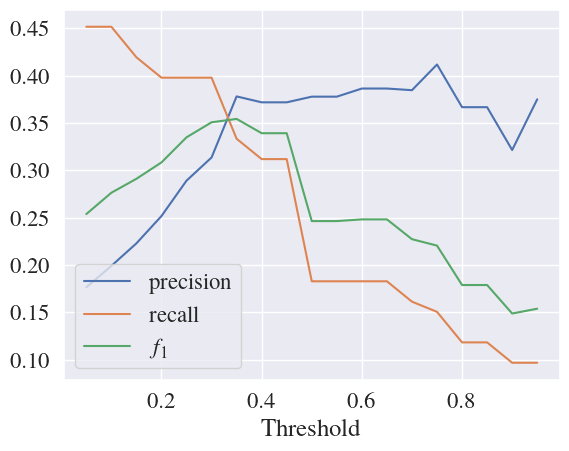

In [87]:
metric_ploter(calibration_prediction_XGB, y_calib)

In [88]:
metric_printer(prediction_XGB, y_test, 0.35)
metric_printer(prediction_XGB, y_test)

Threshold: 0.35
Precision: 0.29
Recall: 0.2
f1 score: 0.24
ROC-AUC: 0.66
Confunsion matrix:
      0    1
0  6059  112
1   186   46
Threshold: 0.5
Precision: 0.38
Recall: 0.14
f1 score: 0.21
ROC-AUC: 0.66
Confunsion matrix:
      0   1
0  6118  53
1   199  33


## Part 2: Counterfactual evaluation and Reject inference

Based on the strategy discussed inb this lecture https://www.youtube.com/watch?v=CJeMJfUYwkM&ab_channel=BuildingNubank (in portuguese).

* We have a rule $\cal{M}$ that approves or not the credit for a client.
* People who are rejected are a **hidden target**, because since we are not providing credit we do not have information about then. 
    * In our dataset they are represented by people with no loan, "X" or -1 in our encoding.
    * The idea here is simple "We have to bet to gain information". We'll only know if someone is a good client if we actually provide credit to this person, otherwise we'll never know.

**Counterfactual problem:** Let's assume we change the rule $\cal{M}$ (my client_classifier(id) function) by $\cal{M}^{\prime}$ (client_classifier2(id) below) and we **randomly** select people that the rule $\cal{M}$ has rejected and approve their credit line.
* In this case, some of them might turn out to be actually good clients and other were really bad clients. By doing so we obtain information about the rejected people. 
* The important thing to take into account here is **what is the cost of the true negatives?** 
    * We use the confusion matrix to infer it.

**1st step:** I'll create two dataset out of the original df_clean. A df_accepted that will be used to train the best model and a df_rejected.

The rejection rule ${\cal M}$ that I consider is that people younger than 30 years old OR with an total amount income less than 40000 can't have a credit card.

In [89]:
df_accepted = df_work[(df_work['AGE'] >= 30) | (df_work['AMT_INCOME_TOTAL'] >= 40000)]

df_rejected = df_work[(df_work['AGE'] < 30) | (df_work['AMT_INCOME_TOTAL'] < 40000)]


In [90]:
df_accepted['AGE'].mean(), df_accepted['AMT_INCOME_TOTAL'].mean(), df_rejected['AGE'].mean(), df_rejected['AMT_INCOME_TOTAL'].mean()

(43.87877178734304, 185793.5355000937, 27.411398705823792, 178520.974987556)

In [91]:
# Obtain target and predictors
y_accepted = df_accepted.CLIENT_CLASSIFICATION

# The "hidden" target is given by:
y_rejected = df_rejected.CLIENT_CLASSIFICATION

# I take off the ID and GENDER and the target
X_accepted = df_accepted.drop(['ID', 'CODE_GENDER', 'CLIENT_CLASSIFICATION'], axis = 1)

X_rejected = df_rejected.drop(['ID', 'CODE_GENDER', 'CLIENT_CLASSIFICATION'], axis = 1)

# The columns that has numerical features
numerical_features = X_accepted.select_dtypes(include=['float64', 'int64']).columns

# The categorical features
categorical_features = X_accepted.select_dtypes(include=['object']).columns

In [92]:
X_accepted_train, X_accepted_test, y_accepted_train, y_accepted_test = train_test_split(X_accepted, y_accepted, test_size=0.2, random_state=42, stratify = y_accepted)

# Defining the training and threshold verification sets
X_accepted_train, X_accepted_calib, y_accepted_train, y_accepted_calib = train_test_split(X_accepted_train, y_accepted_train, test_size = 0.1, random_state = 42, stratify = y_accepted_train)





In [93]:
# Train the best model chosen in the part 1
XGB_accepted_train = pipeline_XGB_optimal.fit(X_accepted_train, y_accepted_train)

# Make the predictions in the accepted dataset
prediction_XGB_accepted = pipeline_XGB_optimal.predict_proba(X_accepted_test)

# Make the predictions in the rejected dataset
prediction_XGB_rejected = pipeline_XGB_optimal.predict_proba(X_rejected)

In [94]:
roc_auc_score(y_accepted_test, prediction_XGB_accepted[:,1]), roc_auc_score(y_rejected, prediction_XGB_rejected[:,1])

(0.6624153437379511, 0.8921557817128419)

In [95]:
# Fuzzy strategy
df_fuzzy = pd.concat(
    [df_rejected.assign(Target = 1).assign(sample_weigth = prediction_XGB_rejected[:,1]), # Put the rejected clients with the label of bad clients with the probability given by the predict_proba.
     df_rejected.assign(Target = 0).assign(sample_weigth = prediction_XGB_rejected[:,0]), # Now, the same guys are put with the label of good clients.
     df_accepted.assign(Target = lambda df_: df_.CLIENT_CLASSIFICATION).assign(sample_weigth = 1)]
)

In [96]:
df_fuzzy

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CLIENT_CLASSIFICATION,AGE,YEARS_EMPLOYED,AMT_INCOME_PER_PERSON,AMT_INCOME_PER_CHILD,Target,sample_weigth
18,5008825,F,Y,N,0,130500.0,Working,Incomplete higher,Married,House / apartment,...,0,Accountants,2.0,0,29.0,3.0,65250.0,-1.0,1,0.000555
19,5008826,F,Y,N,0,130500.0,Working,Incomplete higher,Married,House / apartment,...,0,Accountants,2.0,0,29.0,3.0,65250.0,-1.0,1,0.000555
20,5008830,F,N,Y,0,157500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,Laborers,2.0,0,27.0,4.0,78750.0,-1.0,1,0.000344
21,5008831,F,N,Y,0,157500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,Laborers,2.0,0,27.0,4.0,78750.0,-1.0,1,0.000344
22,5008832,F,N,Y,0,157500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,Laborers,2.0,0,27.0,4.0,78750.0,-1.0,1,0.000344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,...,0,Managers,2.0,1,47.0,7.0,157500.0,-1.0,1,1.000000
36453,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,...,1,Medicine staff,2.0,0,34.0,4.0,78750.0,-1.0,0,1.000000
36454,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,...,1,Medicine staff,2.0,0,34.0,4.0,78750.0,-1.0,0,1.000000
36455,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,Sales staff,2.0,1,49.0,2.0,141750.0,-1.0,1,1.000000


In [97]:
# Obtain target and predictors
y_fuzzy = df_fuzzy.Target

X_fuzzy = df_fuzzy.drop(['ID', 'CODE_GENDER', 'CLIENT_CLASSIFICATION', 'Target'], axis = 1)

# The columns that has numerical features
numerical_features_fuzzy = X_fuzzy.select_dtypes(include=['float64', 'int64']).columns

# The categorical features
categorical_features_fuzzy = X_fuzzy.select_dtypes(include=['object']).columns

In [98]:
X_fuzzy_train, X_fuzzy_test, y_fuzzy_train, y_fuzzy_test = train_test_split(X_fuzzy, y_fuzzy, test_size=0.2, random_state=42, stratify = y_fuzzy)

# Defining the training and threshold verification sets
X_fuzzy_train, X_fuzzy_calib, y_fuzzy_train, y_fuzzy_calib = train_test_split(X_fuzzy_train, y_fuzzy_train, test_size = 0.1, random_state = 42, stratify = y_fuzzy_train)




In [99]:
# Train the best model chosen in the part 1
XGB_fuzzy_train = pipeline_XGB_optimal.fit(X_fuzzy_train, y_fuzzy_train)

# Make the predictions in the fuzzy dataset
prediction_XGB_fuzzy = pipeline_XGB_optimal.predict_proba(X_fuzzy_test)

# Make the predictions in the rejected dataset
prediction_XGB_rejected = pipeline_XGB_optimal.predict_proba(X_rejected)

In [100]:
roc_auc_score(y_accepted_test, prediction_XGB_accepted[:,1]), roc_auc_score(y_rejected, prediction_XGB_rejected[:,1])



(0.6624153437379511, 0.7906708758058896)

In [101]:
def function_draft(model, n_iterations = 5, df_accepted = df_accepted, df_rejected = df_rejected, X_accepted_train = X_accepted_train, y_accepted_train = y_accepted_train, X_rejected = X_rejected, y_rejected = y_rejected):
    # Train the best model chosen in the part 1
    model_train = model.fit(X_accepted_train, y_accepted_train)

    # Make the predictions in the accepted dataset
    model_accepted = model.predict_proba(X_accepted_test)

    # Make the predictions in the rejected dataset
    model_rejected = model.predict_proba(X_rejected)[:,1]
    
    roc = roc_auc_score(y_rejected, model_rejected)
    
    roc_list = [roc]
    
    while n_iterations > 0:
        print(n_iterations)
        
        # Create a new dataframe with the fuzzy strategy - This is the core of the rejected inference
        df_fuzzy = pd.concat(
            [df_rejected.assign(Target = 1).assign(sample_weigth = model_rejected[:,1]), # Put the rejected clients with the label of bad clients with the probability given by the predict_proba.
             df_rejected.assign(Target = 0).assign(sample_weigth = model_rejected[:,0]), # Now, the same guys are put with the label of good clients.
             df_accepted.assign(Target = lambda df_: df_.CLIENT_CLASSIFICATION).assign(sample_weigth = 1)]
        )

        # Obtain target and features
        y_fuzzy = df_fuzzy.Target

        X_fuzzy = df_fuzzy.drop(['ID', 'CODE_GENDER', 'CLIENT_CLASSIFICATION', 'Target'], axis = 1)

        # The columns that has numerical features
        numerical_features_fuzzy = X_fuzzy.select_dtypes(include=['float64', 'int64']).columns

        # The categorical features
        categorical_features_fuzzy = X_fuzzy.select_dtypes(include=['object']).columns

        X_fuzzy_train, X_fuzzy_test, y_fuzzy_train, y_fuzzy_test = train_test_split(X_fuzzy, y_fuzzy, test_size=0.2, random_state=42, stratify = y_fuzzy)

        # Defining the training and threshold verification sets
        X_fuzzy_train, X_fuzzy_calib, y_fuzzy_train, y_fuzzy_calib = train_test_split(X_fuzzy_train, y_fuzzy_train, test_size = 0.1, random_state = 42, stratify = y_fuzzy_train)

        # Train the best model chosen in the part 1
        model_fuzzy_train = model.fit(X_fuzzy_train, y_fuzzy_train)

        # Make the predictions in the fuzzy dataset
        prediction_fuzzy_test = model.predict_proba(X_fuzzy_test)

        # Make the predictions in the rejected dataset
        prediction_fuzzy_rejected = model.predict_proba(X_rejected)[:,1]

        roc = roc_auc_score(y_rejected, prediction_fuzzy_rejected)
        
        model_rejected = prediction_fuzzy_rejected
        
        roc_list.append(roc)
        
        n_iterations -= 1
    
    return [roc, roc_list, prediction_fuzzy_rejected]

In [102]:
%%time
rejected_inference_results = function_draft(pipeline_XGB_optimal)

5


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [103]:
import sklearn
print(sklearn.show_versions())


System:
    python: 3.11.3 (main, Apr 19 2023, 18:51:09) [Clang 14.0.6 ]
executable: /Users/brunogoes/anaconda3/bin/python
   machine: macOS-10.16-x86_64-i386-64bit

Python dependencies:
      sklearn: 1.3.0
          pip: 23.2.1
   setuptools: 67.8.0
        numpy: 1.24.3
        scipy: 1.11.1
       Cython: None
       pandas: 1.5.3
   matplotlib: 3.7.1
       joblib: 1.2.0
threadpoolctl: 2.2.0

Built with OpenMP: True

threadpoolctl info:
       filepath: /Users/brunogoes/anaconda3/lib/libopenblasp-r0.3.21.dylib
         prefix: libopenblas
       user_api: blas
   internal_api: openblas
        version: 0.3.21
    num_threads: 8
threading_layer: pthreads
   architecture: Haswell

       filepath: /Users/brunogoes/anaconda3/lib/libomp.dylib
         prefix: libomp
       user_api: openmp
   internal_api: openmp
        version: None
    num_threads: 16
None
